## Interval arithmetic

## Taylor model arithmetic

In [1]:
using TaylorModels

In [2]:
using ReachabilityAnalysis, LazySets, Plots

In [3]:
Z = rand(Zonotope)

Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([1.3417054907360892, -0.7625713469625908], [0.7200947906961055 -0.20273631884826754; 0.3921543815075854 0.3508040631466221])

## Taylor model integration

In [ ]:
Given an ODE $x' = f(x, t)$ 

*Pseudocode.*

For i in 1, ..N, do
    Comute a Taylor expansion $p_i(x_i, t)$ of the ODE solution from $x_i$
    Evaluate an inteval remainder the $I_i$ such that $(p_i, I_i)$ is a TM for the ODE solution when $X_

In [87]:
Z = rand(Zonotope, dim=2)
R = ReachSet(Z, 0 .. 1)

ReachSet{Float64,Zonotope{Float64,Array{Float64,1},Array{Float64,2}}}(Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([0.38445227436957413, -0.35888561941916974], [-1.053189446141972 -0.3464646244111049; 0.08025950405128496 -2.236271461611677]), [0, 1])

In [88]:
overapproximate(R, TaylorModelReachSet)

LoadError: MethodError: no method matching reconstruct(::ReachSet{Float64,Zonotope{Float64,Array{Float64,1},Array{Float64,2}}}, ::TaylorModelReachSet{Float64})
Closest candidates are:
  reconstruct(::ReachSet, !Matched::LazySet) at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Flowpipes/reachsets.jl:382
  reconstruct(!Matched::TaylorModelReachSet, ::Any) at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Flowpipes/reachsets.jl:631

In [85]:
convert(TaylorModelReachSet, R) # doesn't necessarily work because the order of Z is not one << FIXME

LoadError: MethodError: Cannot `convert` an object of type 
  ReachSet{Float64,Zonotope{Float64,Array{Float64,1},Array{Float64,2}}} to an object of type 
  TaylorModelReachSet
Closest candidates are:
  convert(::Type{var"#s20"} where var"#s20"<:TaylorModelReachSet, !Matched::AbstractHyperrectangle{N}; orderQ, orderT, Δt) where N at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Flowpipes/reachsets.jl:722
  convert(::Type{T}, !Matched::Intervals.Interval{T,L,R} where R<:Intervals.Bound where L<:Intervals.Bound) where T at /home/mforets/.julia/packages/Intervals/ua9cq/src/interval.jl:253
  convert(::Type{T}, !Matched::Intervals.AnchoredInterval{P,T,L,R} where R<:Intervals.Bounded where L<:Intervals.Bounded) where {P, T} at /home/mforets/.julia/packages/Intervals/ua9cq/src/anchoredinterval.jl:181
  ...

## TM flowpipe construction for linear ODEs: HOMOGENEOUS case

We solve the sequence

$$
F_i = \Phi F_{i-1}, \qquad i = 2,3, \ldots, N
$$

where $F_i$ is an overapproximation of the exact reachable set $\{\varphi(x_0, t) : t \in [(i-1)\delta, i\delta]\}$.

## 1) Computing the first flowpipe

In [6]:
using LinearAlgebra

In [7]:
order = 50
t = Taylor1(order)

p = t^2 + 2t + 1

 1.0 + 2.0 t + 1.0 t² + 𝒪(t⁵¹)

In [8]:
A = [0 1; -1 0.]

2×2 Array{Float64,2}:
  0.0  1.0
 -1.0  0.0

In [9]:
# expand e^(At) into a Taylor series
# up to order k
function _exp(A; order)
    t = Taylor1(order)

    n = size(A, 1)
    Iₙ = Matrix(1.0I, n, n)
    At = A*t
    W = Iₙ + At
    Q = copy(At) # stores A^i t^i / i!

    for i in 2:order
        Q = Q * At / i
        W += Q
    end
    return W
end

_exp (generic function with 1 method)

In [10]:
A = [0 1; -1 0.]
exp(A)

2×2 Array{Float64,2}:
  0.540302  0.841471
 -0.841471  0.540302

In [11]:
W = _exp(A, order=10)
W[1, 1]

 1.0 - 0.5 t² + 0.041666666666666664 t⁴ - 0.0013888888888888887 t⁶ + 2.4801587301587298e-5 t⁸ - 2.7557319223985883e-7 t¹⁰ + 𝒪(t¹¹)

In [12]:
W10 = TaylorSeries.evaluate.(W, 1.0)

2×2 Array{Float64,2}:
  0.540302  0.841471
 -0.841471  0.540302

### Using eigendecomposition

In [13]:
E = eigen(A)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
2-element Array{Complex{Float64},1}:
 0.0 - 1.0im
 0.0 + 1.0im
vectors:
2×2 Array{Complex{Float64},2}:
 0.707107-0.0im       0.707107+0.0im
      0.0-0.707107im       0.0+0.707107im

In [14]:
D = Diagonal(E.values)

2×2 Diagonal{Complex{Float64},Array{Complex{Float64},1}}:
 0.0-1.0im      ⋅    
     ⋅      0.0+1.0im

In [15]:
V = E.vectors

2×2 Array{Complex{Float64},2}:
 0.707107-0.0im       0.707107+0.0im
      0.0-0.707107im       0.0+0.707107im

In [16]:
V * D * V'

2×2 Array{Complex{Float64},2}:
  0.0+0.0im  1.0+0.0im
 -1.0+0.0im  0.0+0.0im

In [17]:
A

2×2 Array{Float64,2}:
  0.0  1.0
 -1.0  0.0

In [18]:
# expand e^(At) into a Taylor series
# up to order k using the eigendecomposition of A
function _exp_eigen(A; order)
    t = Taylor1(order)

    E = eigen(A)
    V = E.vectors
    D = Diagonal([exp(v*t) for v in E.values])
    W = V * D * V'
end

_exp_eigen (generic function with 1 method)

In [19]:
Wc5 = _exp_eigen(A, order=6)

Wc5 = TaylorSeries.evaluate.(Wc5, 1.0)

2×2 Array{Complex{Float64},2}:
  0.540278+0.0im  0.841667+0.0im
 -0.841667+0.0im  0.540278+0.0im

In [20]:
exp(A)

2×2 Array{Float64,2}:
  0.540302  0.841471
 -0.841471  0.540302

In [21]:
W5 = _exp(A, order=6)

W5 = TaylorSeries.evaluate.(W5, 1.0)

2×2 Array{Float64,2}:
  0.540278  0.841667
 -0.841667  0.540278

## Truncation error

In [45]:
# expand e^(At) into a Taylor series
# up to order k
function _exp_with_error(A, δ; order)
    t = Taylor1(order+1)

    n = size(A, 1)
    Iₙ = Matrix(1.0I, n, n)
    At = A*t
    W = Iₙ + At
    Q = copy(At) # stores A^i t^i / i!

    for i in 2:order
        Q = Q * At / i
        W += Q
    end
    
    # here Q = A^k t^k / k!
    Anorm = opnorm(A, Inf)
    ρ = exp(Anorm * δ)
    Mρ = IntervalArithmetic.Interval(-ρ, ρ)
    
    # IΦ = Q * At / (k+1) * Mρ # FIXME
    IΦ = broadcast(x -> x * Mρ, Q*At/(order+1))

    return W, IΦ
end

_exp_with_error (generic function with 1 method)

In [56]:
W, IΦ = _exp_with_error(A, 1.0, order=4)

(Taylor1{Float64}[ 1.0 - 0.5 t² + 0.041666666666666664 t⁴ + 𝒪(t⁶)  1.0 t - 0.16666666666666666 t³ + 𝒪(t⁶);  - 1.0 t + 0.16666666666666666 t³ + 𝒪(t⁶)  1.0 - 0.5 t² + 0.041666666666666664 t⁴ + 𝒪(t⁶)], Taylor1{IntervalArithmetic.Interval{Float64}}[ [0, 0] + 𝒪(t⁶)  [-0.0226524, 0.0226524] t⁵ + 𝒪(t⁶);  [-0.0226524, 0.0226524] t⁵ + 𝒪(t⁶)  [0, 0] + 𝒪(t⁶)])

In [77]:
W[1, 1]

 1.0 - 0.5 t² + 0.041666666666666664 t⁴ + 𝒪(t⁶)

In [57]:
TaylorSeries.evaluate.(W, 1.0)

2×2 Array{Float64,2}:
  0.541667  0.833333
 -0.833333  0.541667

In [58]:
exp(A * 0.1)

2×2 Array{Float64,2}:
  0.995004   0.0998334
 -0.0998334  0.995004

In [60]:
IΦ[1, 2]

 [-0.0226524, 0.0226524] t⁵ + 𝒪(t⁶)

---

In [61]:
A

2×2 Array{Float64,2}:
  0.0  1.0
 -1.0  0.0

A box is parameterized by the set

$$
X_0 = \{(1 + 0.1 x_1, 1+0.1 x_2) : (x_1, x_2) \in [-1, 1] \}
$$

In [78]:
W[1, 1]

 1.0 - 0.5 t² + 0.041666666666666664 t⁴ + 𝒪(t⁶)

In [74]:
@taylorize function f(dx, x, p, t)
    dx[1] = x[2]
    dx[2] = -x[1]
end

X0 = BallInf(ones(2), 0.1)
prob = @ivp(x' = f(x), x(0) ∈ X0, dim=2)

sol = solve(prob, tspan=(0.0, 7.0), alg=TMJets());

In [75]:
using ReachabilityAnalysis: set

X = set(sol[1])

X[1]

  1.0 + 0.10000000000000003 x₁ + ( 1.0 + 0.10000000000000003 x₂) t + ( - 0.5 - 0.05000000000000002 x₁) t² + ( - 0.16666666666666666 - 0.01666666666666667 x₂) t³ + ( 0.041666666666666664 + 0.0041666666666666675 x₁) t⁴ + ( 0.008333333333333333 + 0.0008333333333333335 x₂) t⁵ + ( - 0.0013888888888888887 - 0.00013888888888888892 x₁) t⁶ + ( - 0.00019841269841269839 - 1.9841269841269845e-5 x₂) t⁷ + ( 2.4801587301587298e-5 + 2.4801587301587306e-6 x₁) t⁸ + [-3.45506e-15, 2.43364e-14]

In [76]:
X[2]

  1.0 + 0.10000000000000003 x₂ + ( - 1.0 - 0.10000000000000003 x₁) t + ( - 0.5 - 0.05000000000000002 x₂) t² + ( 0.16666666666666666 + 0.01666666666666667 x₁) t³ + ( 0.041666666666666664 + 0.0041666666666666675 x₂) t⁴ + ( - 0.008333333333333333 - 0.0008333333333333335 x₁) t⁵ + ( - 0.0013888888888888887 - 0.00013888888888888892 x₂) t⁶ + ( 0.00019841269841269839 + 1.9841269841269845e-5 x₁) t⁷ + ( 2.4801587301587298e-5 + 2.4801587301587306e-6 x₂) t⁸ + [-2.73298e-14, 4.47618e-16]

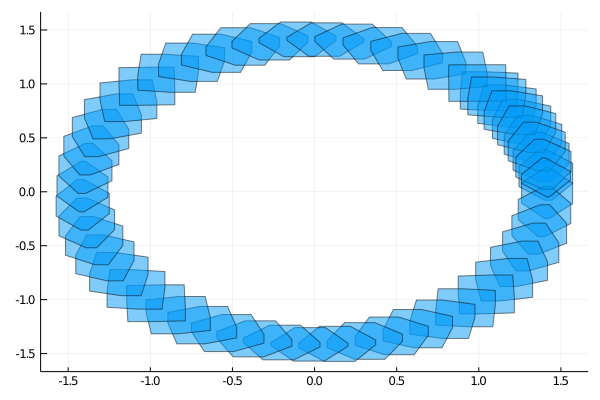

In [65]:
plot(sol, vars=(1, 2))